In [36]:
import matplotlib.pyplot as plt
import pandas as pd
# import talib
import numpy as np
# import lightgbm as lgb
import pyfolio as pf

In [37]:
import tensorflow as tf
from tensorflow.python.client import device_lib

In [38]:
print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18156292758546203800
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8841186134590102799
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16023867368901430246
physical_device_desc: "device: XLA_GPU device"
]


In [39]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [40]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [41]:
#Step1 Get Original Data from Interactivebroker
filename = "quandl_N4N_5D_20071001~20200313.csv" #from IB
df = pd.read_csv(filename,index_col = 0)
# df.reset_index(drop=True,inplace=True)
print(df.shape)
print(df.head(1))
print(df.tail(1))

(5334, 21)
            SPF  DJF  Oil  GOLD  USD  TBF  TN5      SPFy  SPFclose  DJFy  ...  \
Date                                                                      ...   
2000-01-04  NaN  NaN  NaN   NaN  NaN  NaN  NaN  1.030103    1411.8   NaN  ...   

               GOLDy  GOLDclose      Oily  Oilclose      USDy  USDclose  \
Date                                                                      
2000-01-04  1.002664      281.5  1.008611     25.55  1.001598     100.1   

                TBFy  TBFclose      TN5y   TN5close  
Date                                                 
2000-01-04  0.984828    90.625  0.993776  97.914062  

[1 rows x 21 columns]
                 SPF       DJF       Oil  GOLD       USD       TBF       TN5  \
Date                                                                           
2020-06-12  0.008139  0.014743 -0.002201   NaN  0.005851 -0.006598 -0.000745   

            SPFy  SPFclose  DJFy  ...  GOLDy  GOLDclose  Oily  Oilclose  USDy  \
Date        

In [42]:
#Step2 check data

#Check NAN
print(df.isnull().values.any() )
print("before dropping NaN", df.shape)
df.dropna(inplace=True)
print("after dropping NaN", df.shape)

# print( df.info() )
print(type(df.index[0]), df.index[0])
df.index = pd.to_datetime(df.index)
# print( df.info() )
print(type(df.index[0]), df.index[0])

True
before dropping NaN (5334, 21)
after dropping NaN (3097, 21)
<class 'str'> 2007-10-02
<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2007-10-02 00:00:00


                 SPF       DJF       Oil      GOLD       USD       TBF  \
Date                                                                     
2007-10-02 -0.001285 -0.003602 -0.002368 -0.015488  0.005012  0.002515   

                 TN5      SPFy  SPFclose      DJFy  ...    GOLDy  GOLDclose  \
Date                                                ...                       
2007-10-02  0.001607  1.013894    1554.6  1.009287  ...  1.00684      731.0   

                Oily  Oilclose      USDy  USDclose      TBFy  TBFclose  \
Date                                                                     
2007-10-02  1.002623     80.05  1.002685      78.2  0.989116     112.0   

                TN5y    TN5close  
Date                              
2007-10-02  0.993437  107.140625  

[1 rows x 21 columns]
                 SPF       DJF       Oil      GOLD       USD       TBF  \
Date                                                                     
2020-03-06 -0.017045 -0.010399 -0.100654

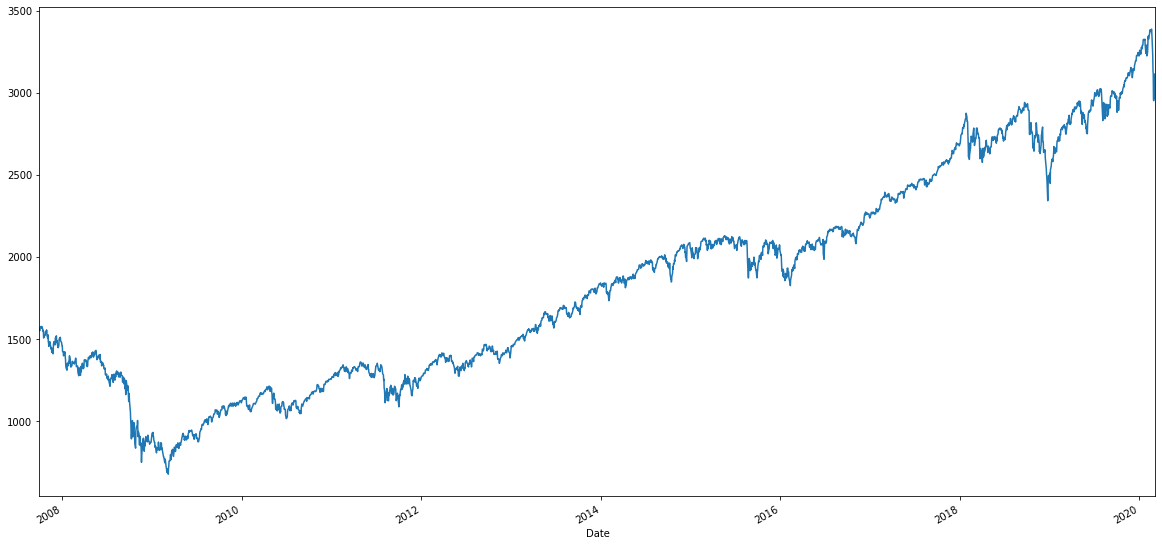

In [43]:
#Step Clean Data
tc=df.SPFclose #targetclose
plt.rcParams["figure.figsize"] = (20,10)
tc.plot()
print(df.head(1))
print(df.tail(1))
print(tc[0])
print(tc[-1])

In [44]:
# NN Preprocess

In [45]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# dataset_scaled = ss.fit_transform(dataset[feature_names])
# dataset_scaled = pd.DataFrame(dataset_scaled, index=dataset.index, columns=feature_names)
# dataset_scaled['return'] = dataset['return']
# dataset_scaled.describe()

In [46]:
print(df.head(1))
print(df.tail(1))
dataset_scaled = df
feature_names = ['SPF', 'DJF','Oil','GOLD', 'USD', 'TBF', 'TN5']#df.columns[:-2]
y_names = ['SPFy','DJFy','Oily','GOLDy','USDy','TBFy','TN5y']
print("feature_names",feature_names)
print("y_names",y_names)

                 SPF       DJF       Oil      GOLD       USD       TBF  \
Date                                                                     
2007-10-02 -0.001285 -0.003602 -0.002368 -0.015488  0.005012  0.002515   

                 TN5      SPFy  SPFclose      DJFy  ...    GOLDy  GOLDclose  \
Date                                                ...                       
2007-10-02  0.001607  1.013894    1554.6  1.009287  ...  1.00684      731.0   

                Oily  Oilclose      USDy  USDclose      TBFy  TBFclose  \
Date                                                                     
2007-10-02  1.002623     80.05  1.002685      78.2  0.989116     112.0   

                TN5y    TN5close  
Date                              
2007-10-02  0.993437  107.140625  

[1 rows x 21 columns]
                 SPF       DJF       Oil      GOLD       USD       TBF  \
Date                                                                     
2020-03-06 -0.017045 -0.010399 -0.100654

In [47]:
import tqdm

n = 20

X = []
y = []
indexes = []
dataset_scaled_x = dataset_scaled[feature_names]
dataset_scaled_y = dataset_scaled[y_names]


print(dataset_scaled_x.head(1))
print(dataset_scaled_y.head(1))

                 SPF       DJF       Oil      GOLD       USD       TBF  \
Date                                                                     
2007-10-02 -0.001285 -0.003602 -0.002368 -0.015488  0.005012  0.002515   

                 TN5  
Date                  
2007-10-02  0.001607  
                SPFy      DJFy      Oily    GOLDy      USDy      TBFy  \
Date                                                                    
2007-10-02  1.013894  1.009287  1.002623  1.00684  1.002685  0.989116   

                TN5y  
Date                  
2007-10-02  0.993437  


In [48]:
for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-n)):
    X.append(dataset_scaled_x.iloc[i:i+n].values)
    y.append(dataset_scaled_y.iloc[i+n-1])
    indexes.append(dataset_scaled.index[i+n-1])
print(dataset_scaled.head())
print(dataset_scaled.tail())



                 SPF       DJF       Oil      GOLD       USD       TBF  \
Date                                                                     
2007-10-02 -0.001285 -0.003602 -0.002368 -0.015488  0.005012  0.002515   
2007-10-03 -0.002509 -0.003828 -0.001374 -0.001026  0.003325 -0.001393   
2007-10-04  0.000967 -0.000783  0.018764 -0.006505 -0.001020  0.002235   
2007-10-05  0.011919  0.008190 -0.002701  0.015851 -0.001850 -0.011713   
2007-10-09  0.008639  0.008858  0.015692  0.003066 -0.001782  0.000000   

                 TN5      SPFy  SPFclose      DJFy  ...     GOLDy  GOLDclose  \
Date                                                ...                        
2007-10-02  0.001607  1.013894    1554.6  1.009287  ...  1.006840     731.00   
2007-10-03 -0.001167  1.014574    1550.7  1.006405  ...  1.015063     730.25   
2007-10-04  0.000876  1.008375    1552.2  1.003205  ...  1.032391     725.50   
2007-10-05 -0.005106  1.002483    1570.7  1.001625  ...  1.016961     737.00   


In [49]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [50]:
print(len(X))

3077


In [51]:
indexes = np.array(indexes)

In [52]:
print(indexes)

[Timestamp('2007-10-30 00:00:00') Timestamp('2007-10-31 00:00:00')
 Timestamp('2007-11-02 00:00:00') ... Timestamp('2020-03-03 00:00:00')
 Timestamp('2020-03-04 00:00:00') Timestamp('2020-03-05 00:00:00')]


In [53]:
# LSTM Model

In [54]:
#LV1

In [55]:
import keras
#one layer lstm
model = keras.models.Sequential()
#model.add(keras.layers.Dense(100, activation="relu", input_shape=(len(feature_names),)))
# model.add(keras.layers.LSTM(100, return_sequences=True, input_shape=X[0].shape))
model.add(keras.layers.LSTM(100,input_shape=X[0].shape))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(7,kernel_initializer="uniform",activation='linear'))

adam = keras.optimizers.Adam(0.0005)

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               43200     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 63        
Total params: 44,071
Trainable params: 44,071
Non-trainable params: 0
_________________________________________________________________


In [56]:
%%time

# dataset_scaled_train = dataset_scaled[:'2015']
#mac cpu 1min 17 sys 40 total 1min 58 wall 32
#GPU total 1min 14 wall 17.5


import datetime
X_train = X[indexes < datetime.datetime(2017, 1, 1)]
y_train = y[indexes < datetime.datetime(2017, 1, 1)]

get_best_model = keras.callbacks.ModelCheckpoint("N4N_lstm_1L_20f5.mdl", monitor="val_acc")
#xlen 3077
history = model.fit(
    X_train,  
    y_train > 1 , 
    batch_size=500, 
    epochs=300, 
    validation_split=0.2, 
    callbacks=[get_best_model])

Train on 1824 samples, validate on 456 samples
Epoch 1/300
1824/1824 [==============================] - 1s 436us/step - loss: 4.6223 - acc: 0.4610 - val_loss: 3.2211 - val_acc: 0.4762
Epoch 2/300
1824/1824 [==============================] - 0s 73us/step - loss: 3.2135 - acc: 0.4610 - val_loss: 2.9675 - val_acc: 0.4762
Epoch 3/300
1824/1824 [==============================] - 0s 73us/step - loss: 2.9986 - acc: 0.4610 - val_loss: 2.8183 - val_acc: 0.4762
Epoch 4/300
1824/1824 [==============================] - 0s 77us/step - loss: 2.8582 - acc: 0.4610 - val_loss: 2.6993 - val_acc: 0.4762
Epoch 5/300
1824/1824 [==============================] - 0s 73us/step - loss: 2.7385 - acc: 0.4610 - val_loss: 2.5828 - val_acc: 0.4762
Epoch 6/300
1824/1824 [==============================] - 0s 75us/step - loss: 2.6134 - acc: 0.4610 - val_loss: 2.4481 - val_acc: 0.4762
Epoch 7/300
1824/1824 [==============================] - 0s 75us/step - loss: 2.4630 - acc: 0.4610 - val_loss: 2.2713 - val_acc: 0.4762


1824/1824 [==============================] - 0s 83us/step - loss: 0.6887 - acc: 0.5398 - val_loss: 0.6913 - val_acc: 0.5235
Epoch 61/300
1824/1824 [==============================] - 0s 79us/step - loss: 0.6888 - acc: 0.5392 - val_loss: 0.6916 - val_acc: 0.5238
Epoch 62/300
1824/1824 [==============================] - 0s 98us/step - loss: 0.6888 - acc: 0.5395 - val_loss: 0.6913 - val_acc: 0.5244
Epoch 63/300
1824/1824 [==============================] - 0s 82us/step - loss: 0.6887 - acc: 0.5396 - val_loss: 0.6912 - val_acc: 0.5238
Epoch 64/300
1824/1824 [==============================] - 0s 71us/step - loss: 0.6887 - acc: 0.5395 - val_loss: 0.6912 - val_acc: 0.5244
Epoch 65/300
1824/1824 [==============================] - 0s 75us/step - loss: 0.6887 - acc: 0.5397 - val_loss: 0.6914 - val_acc: 0.5235
Epoch 66/300
1824/1824 [==============================] - 0s 74us/step - loss: 0.6887 - acc: 0.5399 - val_loss: 0.6915 - val_acc: 0.5238
Epoch 67/300
1824/1824 [==============================

Epoch 120/300
1824/1824 [==============================] - 0s 76us/step - loss: 0.6885 - acc: 0.5386 - val_loss: 0.6922 - val_acc: 0.5222
Epoch 121/300
1824/1824 [==============================] - 0s 71us/step - loss: 0.6885 - acc: 0.5385 - val_loss: 0.6921 - val_acc: 0.5219
Epoch 122/300
1824/1824 [==============================] - 0s 73us/step - loss: 0.6884 - acc: 0.5387 - val_loss: 0.6921 - val_acc: 0.5226
Epoch 123/300
1824/1824 [==============================] - 0s 72us/step - loss: 0.6884 - acc: 0.5392 - val_loss: 0.6923 - val_acc: 0.5219
Epoch 124/300
1824/1824 [==============================] - 0s 73us/step - loss: 0.6885 - acc: 0.5396 - val_loss: 0.6924 - val_acc: 0.5219
Epoch 125/300
1824/1824 [==============================] - 0s 73us/step - loss: 0.6884 - acc: 0.5396 - val_loss: 0.6921 - val_acc: 0.5241
Epoch 126/300
1824/1824 [==============================] - 0s 71us/step - loss: 0.6884 - acc: 0.5378 - val_loss: 0.6921 - val_acc: 0.5241
Epoch 127/300
1824/1824 [=========

1824/1824 [==============================] - 0s 72us/step - loss: 0.6883 - acc: 0.5402 - val_loss: 0.6926 - val_acc: 0.5210
Epoch 180/300
1824/1824 [==============================] - 0s 74us/step - loss: 0.6884 - acc: 0.5395 - val_loss: 0.6932 - val_acc: 0.5232
Epoch 181/300
1824/1824 [==============================] - 0s 76us/step - loss: 0.6882 - acc: 0.5401 - val_loss: 0.6925 - val_acc: 0.5197
Epoch 182/300
1824/1824 [==============================] - 0s 74us/step - loss: 0.6883 - acc: 0.5397 - val_loss: 0.6923 - val_acc: 0.5197
Epoch 183/300
1824/1824 [==============================] - 0s 72us/step - loss: 0.6883 - acc: 0.5395 - val_loss: 0.6927 - val_acc: 0.5219
Epoch 184/300
1824/1824 [==============================] - 0s 82us/step - loss: 0.6883 - acc: 0.5381 - val_loss: 0.6929 - val_acc: 0.5219
Epoch 185/300
1824/1824 [==============================] - 0s 73us/step - loss: 0.6882 - acc: 0.5383 - val_loss: 0.6927 - val_acc: 0.5210
Epoch 186/300
1824/1824 [=======================

1824/1824 [==============================] - 0s 79us/step - loss: 0.6880 - acc: 0.5413 - val_loss: 0.6932 - val_acc: 0.5197
Epoch 239/300
1824/1824 [==============================] - 0s 76us/step - loss: 0.6880 - acc: 0.5406 - val_loss: 0.6932 - val_acc: 0.5191
Epoch 240/300
1824/1824 [==============================] - 0s 69us/step - loss: 0.6880 - acc: 0.5402 - val_loss: 0.6933 - val_acc: 0.5182
Epoch 241/300
1824/1824 [==============================] - 0s 76us/step - loss: 0.6881 - acc: 0.5403 - val_loss: 0.6935 - val_acc: 0.5175
Epoch 242/300
1824/1824 [==============================] - 0s 72us/step - loss: 0.6881 - acc: 0.5398 - val_loss: 0.6932 - val_acc: 0.5194
Epoch 243/300
1824/1824 [==============================] - 0s 76us/step - loss: 0.6880 - acc: 0.5415 - val_loss: 0.6935 - val_acc: 0.5207
Epoch 244/300
1824/1824 [==============================] - 0s 71us/step - loss: 0.6880 - acc: 0.5408 - val_loss: 0.6932 - val_acc: 0.5179
Epoch 245/300
1824/1824 [=======================

1824/1824 [==============================] - 0s 72us/step - loss: 0.6880 - acc: 0.5400 - val_loss: 0.6937 - val_acc: 0.5172
Epoch 298/300
1824/1824 [==============================] - 0s 74us/step - loss: 0.6879 - acc: 0.5408 - val_loss: 0.6939 - val_acc: 0.5182
Epoch 299/300
1824/1824 [==============================] - 0s 73us/step - loss: 0.6879 - acc: 0.5416 - val_loss: 0.6941 - val_acc: 0.5188
Epoch 300/300
1824/1824 [==============================] - 0s 72us/step - loss: 0.6879 - acc: 0.5416 - val_loss: 0.6936 - val_acc: 0.5191
CPU times: user 3min 12s, sys: 9.99 s, total: 3min 22s
Wall time: 46.9 s


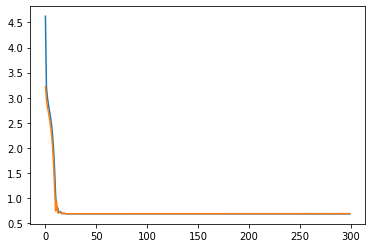

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

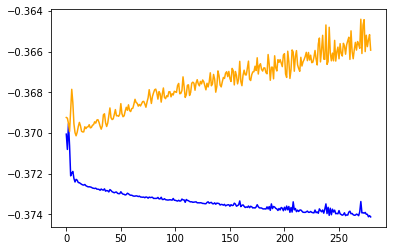

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][20:]),c='blue')
plt.plot(np.log(history.history['val_loss'][20:]),c='orange')

In [59]:
model.load_weights("N4N_lstm_1L_20f5.mdl")

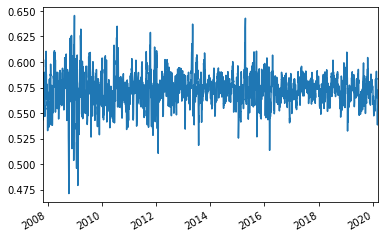

In [60]:
ey = model.predict(X)
ey = pd.Series(ey.swapaxes(0,1)[0], index=indexes)
ey.plot()


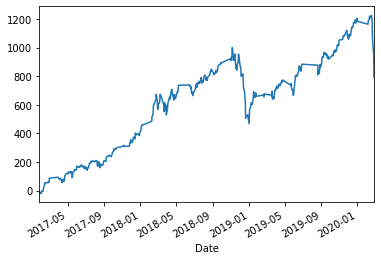

In [61]:
#
eq = tc[indexes]
returns = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.6)).rolling(5).sum() > 0
#No Leg
# signal = signal.shift(1).fillna(False)

eq = (returns[signal]['2017':]).cumsum()
eq.plot()

In [62]:
eq = tc[indexes]


# eq = twii[dataset.index]
# print(type(eq),eq)


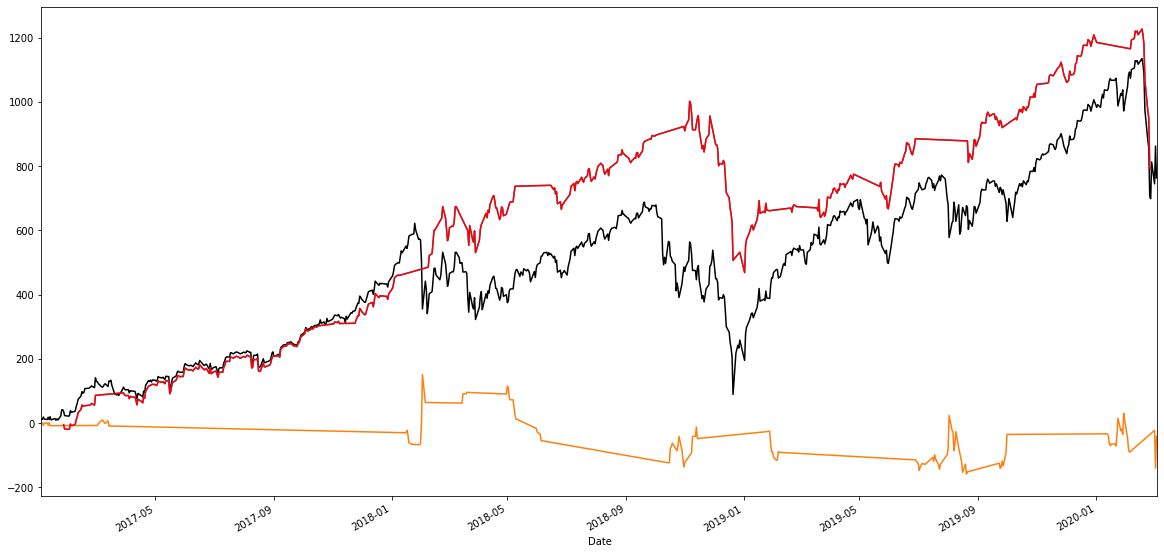

eq 796.3000000000002


In [63]:
plt.rcParams["figure.figsize"] = (20,10)


#(..)
eq = tc[indexes]


returns = (eq.shift(-1) - eq)
# print(eq[2016:][:5])
# print(ey > ey.quantile(0.9))

# print((ey > ey.quantile(0.9)).rolling(10).sum())
signalup = (ey > ey.quantile(0.6)).rolling(5).sum()>0 #r(10) S1.39 40%;r(3) S2.07 28.9%
# print(signalup["2016":][:5])
# signalup = signalup.shift(1).fillna(False) #key with 1.58-> wo 0.24!!!!
# print(signalup["2016":][:5])
signaldn = (ey < ey.quantile(0.1)).rolling(5).sum()>0 #r(10) S-0.3 r(3) S0.47
# print(signaldn[:5])
# signaldn = signaldn.shift(1).fillna(False) #with 0.49 wo -0.3
# print(signaldn[:5])
returns['2017':].cumsum().plot(c="black")
# print(len(eq))
# print(signal[:5])
# print(returns[:5])
equp = (returns[signalup]['2017':])#.cumsum()
# print(type(equp))
equp.cumsum().plot()
eqdn = (-1*returns[signaldn]['2017':])#.cumsum()
eqdn.cumsum().plot()
# print(equp[:5])
# print(eqdn[:5])
# print(len(equp))
# print(len(eqdn))



# eq=equp.add(eqdn, fill_value=0).cumsum() #r(3) r(3) S1.03; r(10) r(3) S1.04 43.5%
# eq=eqdn.add(equp, fill_value=0).cumsum() #same order
#0.6 r3 0.1 r3 -> 0.69 41.1%;
#0.9 r3 0.1 r3 -> 1.03 33%
eq=equp.cumsum()
# eq=eqdn.cumsum()

# print(len(eq))
eq.plot(c='red')
# print(equp[:10])
# print(eqdn[:10])
# print(eq2)
# print(eq)
plt.show()
print("eq",eq[-2])

In [64]:
fee=signal['2017':].astype(int).diff().abs().sum()
print(fee)
print(eq[-2:])
print(eq[-2]-fee)

58.0
Date
2020-02-26    796.3
2020-02-27    790.5
Name: SPFclose, dtype: float64
738.3000000000002


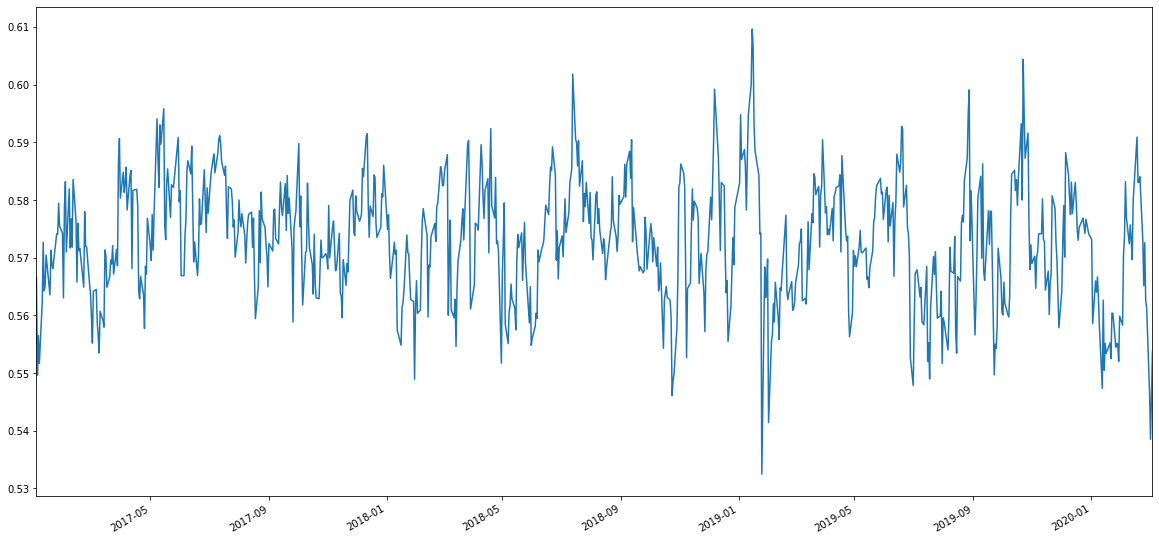

In [65]:
ey["2017":].plot()

508
782


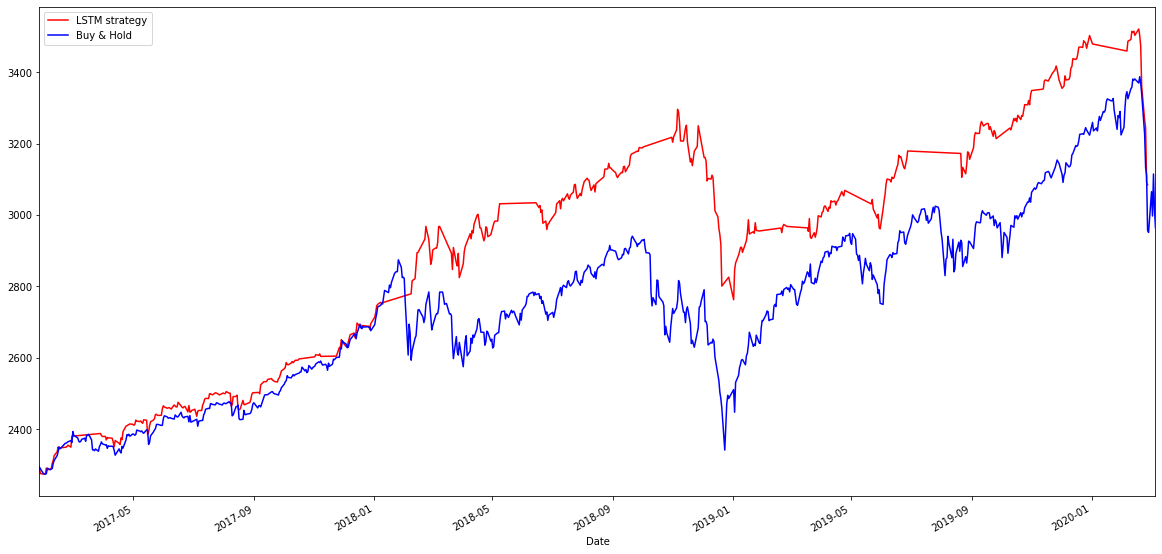

In [66]:
#Benchmark
#(..)
eq_relative = eq + tc[tc.index == eq.index[0]][0]
tw_relative = tc[eq.index[0]:]

plt.rcParams["figure.figsize"] = (20,10)
eq_relative.plot(c="red",  label="LSTM strategy")
tw_relative.plot(c="blue", label="Buy & Hold")
plt.legend(loc='best')

eqpc = eq_relative.pct_change()
bmpc = tw_relative.pct_change() 
print(len(eqpc))
print(len(bmpc))

In [67]:
print(eqpc)

Date
2017-01-26         NaN
2017-01-27   -0.005723
2017-01-30   -0.000659
2017-01-31    0.000000
2017-02-01    0.000396
2017-02-02    0.006856
2017-02-03   -0.001964
2017-02-06    0.000831
2017-02-07    0.000787
2017-02-08    0.006157
2017-02-09    0.003645
2017-02-10    0.005881
2017-02-13    0.004600
2017-02-14    0.005734
2017-02-15   -0.002042
2017-02-16    0.000981
2017-02-22    0.000809
2017-02-23    0.000894
2017-02-24    0.001446
2017-02-27   -0.002335
2017-02-28    0.013065
2017-03-29    0.003193
2017-03-30   -0.002261
2017-03-31   -0.001301
2017-04-03    0.000210
2017-04-04   -0.004202
2017-04-05    0.002996
2017-04-06   -0.000631
2017-04-07    0.000126
2017-04-10   -0.000589
                ...   
2019-12-10    0.002101
2019-12-11    0.007323
2019-12-12    0.001202
2019-12-13    0.006529
2019-12-16   -0.000698
2019-12-17    0.000844
2019-12-18    0.003578
2019-12-19    0.005391
2019-12-20    0.000432
2019-12-23   -0.000432
2019-12-24    0.005391
2019-12-26   -0.001950
2019-1

Start date,2017-01-26
End date,2020-02-27
Total months,24
,Backtest
Annual return,15.9%
Cumulative returns,34.8%
Annual volatility,11.5%
Sharpe ratio,1.34
Calmar ratio,0.99
Stability,0.89
Max drawdown,-16.2%


/home/liaw/anaconda3/envs/finlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.18,2018-11-06,2019-01-02,2019-10-25,254
1,12.39,2020-02-18,2020-02-27,NaT,NaN
2,4.84,2018-02-23,2018-03-29,2018-04-13,36
3,2.48,2018-04-17,2018-04-23,2018-05-08,16
4,2.47,2018-06-15,2018-06-26,2018-07-09,17


/home/liaw/anaconda3/envs/finlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


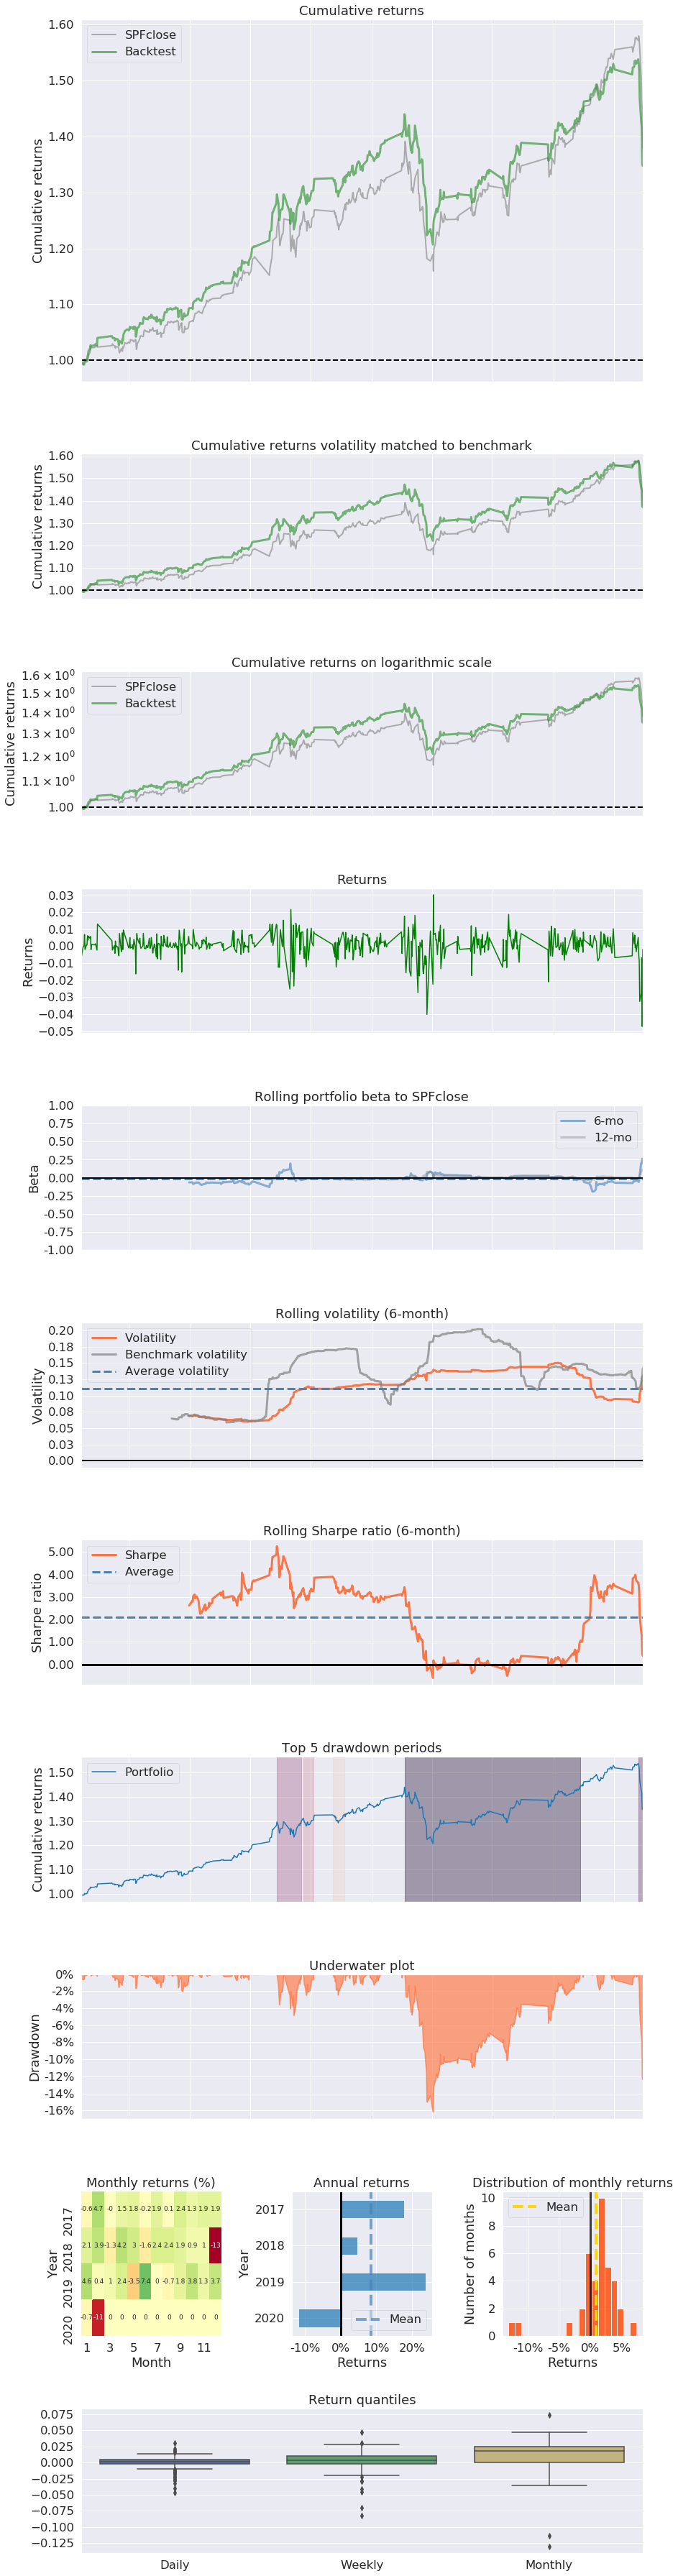

In [68]:
import pyfolio as pf 
pf.create_returns_tear_sheet( eqpc, benchmark_rets = bmpc ) #eq_relative sharpe 0.23

Start date,2017-01-26
End date,2020-03-06
Total months,37
,Backtest
Annual return,8.6%
Cumulative returns,29.2%
Annual volatility,14.3%
Sharpe ratio,0.65
Calmar ratio,0.42
Stability,0.83
Max drawdown,-20.4%


/home/liaw/anaconda3/envs/finlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.36,2018-09-21,2018-12-24,2019-04-26,156
1,12.87,2020-02-19,2020-02-28,NaT,NaN
2,10.42,2018-01-26,2018-04-02,2018-08-24,151
3,6.75,2019-04-30,2019-06-03,2019-06-20,38
4,6.43,2019-07-26,2019-08-05,2019-10-28,67


/home/liaw/anaconda3/envs/finlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


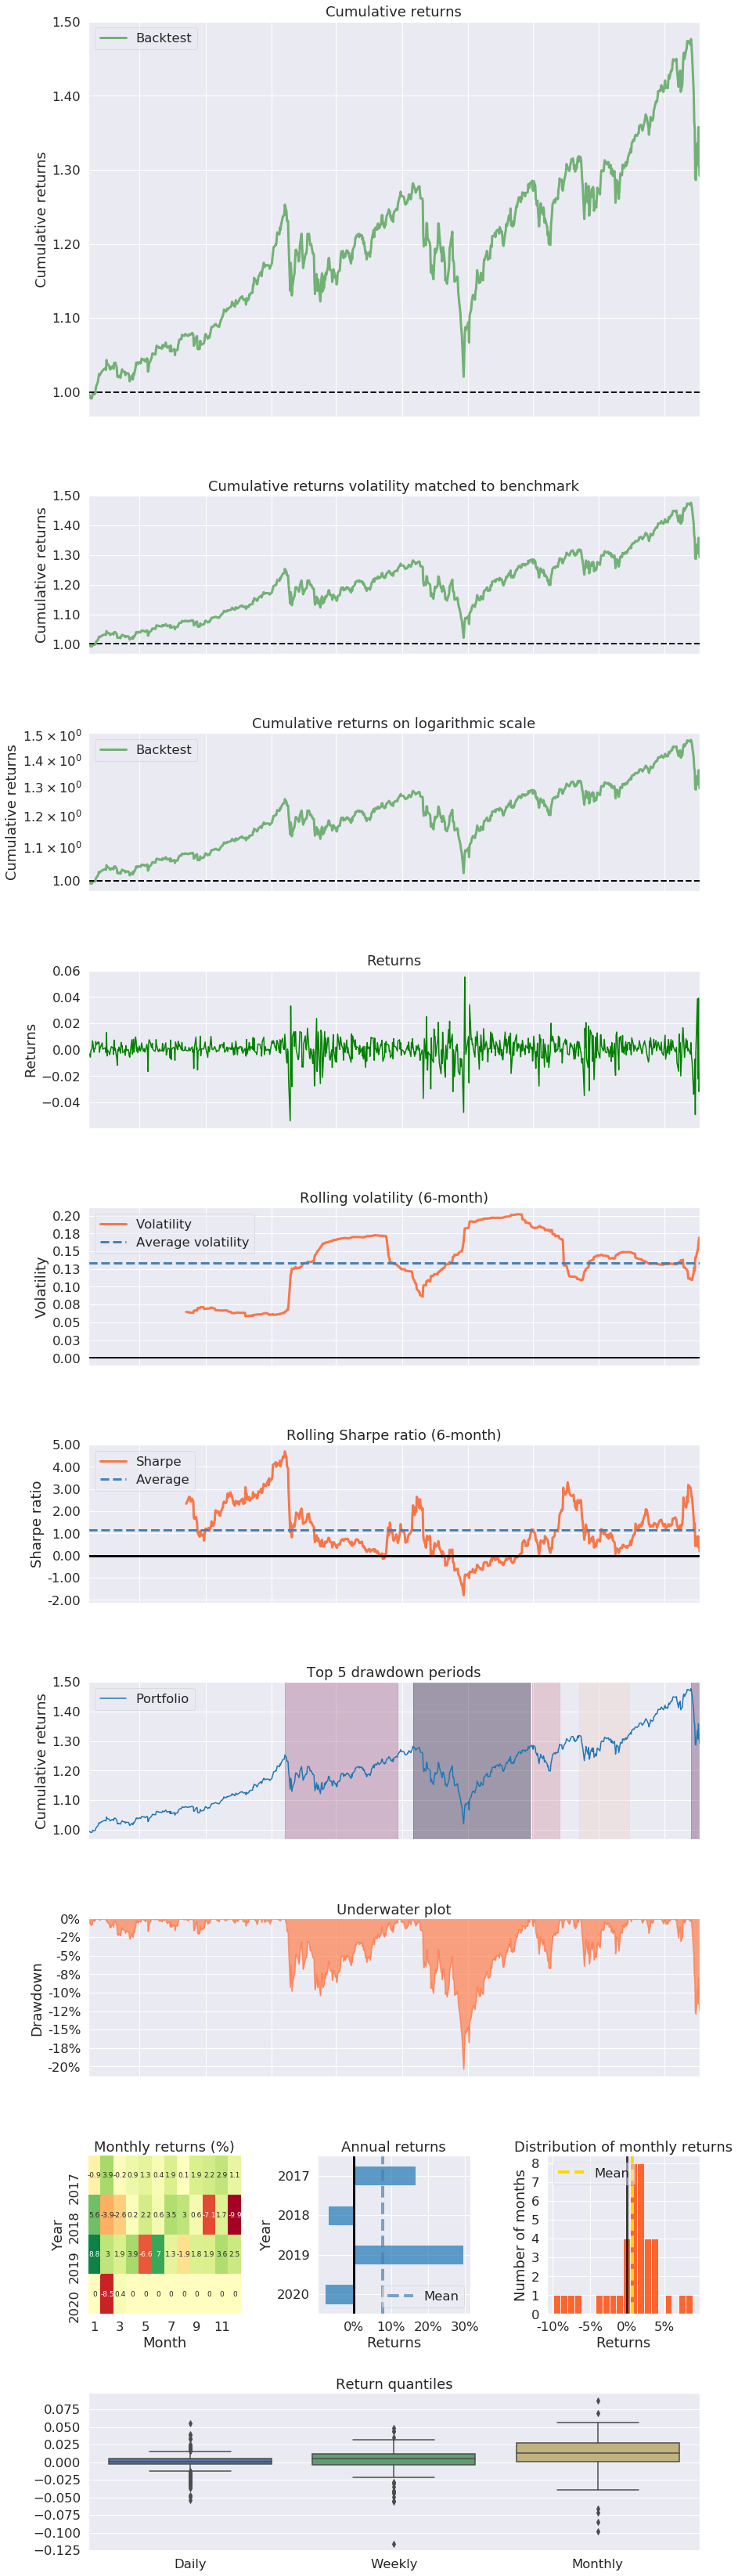

In [69]:
#Benchmark
import pyfolio as pf 
pf.create_returns_tear_sheet(  bmpc ) #eq_relative sharpe 0.23